In [1]:
import sys,os
os.chdir('../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from functions import nufit_params_nsi, nufit_params_nsi_IO
from PINGU.event_processing import return_precomputed_nsi, to_hist
from PINGU.event_processing import get_deltachi as deltachi_PINGU
from DC.event_processing import get_param_list, list_of_params_nsi, get_best_fit
from DC.event_processing import get_deltachi as deltachi_DC
from DC.event_processing import get_marginalized_array as marginalize_DC
from PINGU.event_processing import get_marginalized_array as marginalize_PINGU
from IC.event_processing import get_deltachi as deltachi_IC
from IC.event_processing import normalize_events
from scipy.stats import chi2
import pickle
from scipy.interpolate import splrep, splev, sproot
from src.plotter import save, savethesis
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 400
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
np.set_printoptions(precision=4)

In [58]:
ndim = 3
livetime = 3*365*24*3600 #Effective livetime table1 DC2019 2.45
ordering = 'NO'
IO = False if ordering == 'NO' else True
'''
dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=5, 
                                                                                   th23N=5, 
                                                                          ett_tuple=(-7e-2,7e-2,1), 
                                                                          emt_tuple=(-2e-2,2e-2,10), 
                                                                          eem_tuple=(-2.5e-1,2.5e-1,1), 
                                                                          eet_tuple=(-2.5e-1,2.5e-1,1), 
                                                                          IO=IO)
'''
dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=5, 
                                                                                   th23N=5, 
                                                                          ett_tuple=(-5e-2,5e-2,1), 
                                                                          emt_tuple=(-2e-2,2e-2,10), 
                                                                          eem_tuple=(-2e-1,2e-1,1), 
                                                                          eet_tuple=(-2e-1,2e-1,1), 
                                                                          IO=IO)

In [59]:
param_dict = nufit_params_nsi_IO if ordering == 'IO' else nufit_params_nsi     
param_list = list_of_params_nsi(param_dict, dm31_range, th23_range,ett_range, emt_range, eem_range,eet_range) 

In [60]:
H1_DC = pickle.load(open(f'./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime

H1_PINGU = pickle.load(open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime

H0_PINGU = pickle.load(open(f'./pre_computed/H0_{ordering}_PINGU.p','rb'))*livetime


if len(emt_range) > 1:
    N=13
    H1_events_list = pickle.load(open(f'./pre_computed/H1_NO_IC_N{N}_{len(dm31_range)}x{len(th23_range)}x{len(emt_range)}.p','rb'))
    H0_events = pickle.load(open(f'./pre_computed/H0_IC_N{N}_nsi.p','rb'))
    H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,np.arange(0,20))
    H1_IC = np.array(H1_list_normalized)

In [61]:
sigma_a = 0.25
sigma_b = 0.04
f_PINGU = 0.05
f_DC = 1
f_IC = 0.15
marginalized_arrays_NO=[]
marginalized_arrays_IO=[]
nsi_param_range=[]


D_chisq  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'joint', sigma_a,sigma_b, f_DC)

P_chisq = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'joint', sigma_a,sigma_b, f_PINGU)



PD_chisq =  P_chisq  + D_chisq - P_chisq.min() - D_chisq.min()

PD_best_fit_index = np.argmin(PD_chisq)
PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,PD_best_emt_index,PD_best_eem_index,PD_best_eet_index = np.unravel_index(PD_best_fit_index,PD_chisq.shape)

P_best_fit_index = np.argmin(P_chisq)
P_best_dm31_index,P_best_th23_index,P_best_ett_index,P_best_emt_index,P_best_eem_index,P_best_eet_index = np.unravel_index(P_best_fit_index,P_chisq.shape)

D_best_fit_index = np.argmin(D_chisq)
D_best_dm31_index,D_best_th23_index,D_best_ett_index,D_best_emt_index,D_best_eem_index,D_best_eet_index = np.unravel_index(D_best_fit_index,D_chisq.shape)

In [62]:
if len(emt_range) > 1:
    I_chisq, IC_best_index = deltachi_IC(H1_IC,0,[sigma_a,sigma_b],f_IC,x0=[1,0])
    ID_chisq =  D_chisq + I_chisq.reshape(len(dm31_range),len(th23_range),1,len(emt_range),1,1)
    PID_chisq =  PD_chisq + I_chisq.reshape(len(dm31_range),len(th23_range),1,len(emt_range),1,1)

    I_chisq = I_chisq.reshape(len(emt_range),len(th23_range), len(dm31_range)).T

    I_best_emt_index,I_best_th23_index, I_best_dm31_index = np.unravel_index(IC_best_index,I_chisq.T.shape)
    I_best_dm31, I_best_th23, I_best_emt = (dm31_range[I_best_dm31_index], 
                                                th23_range[I_best_th23_index],
                                                emt_range[I_best_emt_index])
    ID_best_fit_index = np.argmin(ID_chisq)
    ID_best_dm31_index,ID_best_th23_index,ID_best_ett_index,ID_best_emt_index,ID_best_eem_index,ID_best_eet_index = np.unravel_index(ID_best_fit_index,ID_chisq.shape)

    I_best_fit_index = np.argmin(I_chisq)
    I_best_dm31_index,I_best_th23_index,I_best_emt_index = np.unravel_index(I_best_fit_index,I_chisq.shape)

    PID_best_fit_index = np.argmin(PID_chisq)
    PID_best_dm31_index,PID_best_th23_index,PID_best_ett_index,PID_best_emt_index,PID_best_eem_index,PID_best_eet_index = np.unravel_index(PID_best_fit_index,PID_chisq.shape)

    finer_e_range = np.linspace(emt_range.min(),emt_range.max(),49)
    I_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, I_chisq[I_best_dm31_index,I_best_th23_index,:]))
    I_interpolated_emt = I_interpolated_chisq_emt - I_interpolated_chisq_emt.min()

    PID_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, PID_chisq[PID_best_dm31_index,PID_best_th23_index,PID_best_ett_index,:,PID_best_eem_index,PID_best_eet_index]))
    PID_interpolated_emt = PID_interpolated_chisq_emt - PID_interpolated_chisq_emt.min()

    ID_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, ID_chisq[ID_best_dm31_index,ID_best_th23_index,ID_best_ett_index,:,ID_best_eem_index,ID_best_eet_index]))
    ID_interpolated_emt = ID_interpolated_chisq_emt - ID_interpolated_chisq_emt.min()

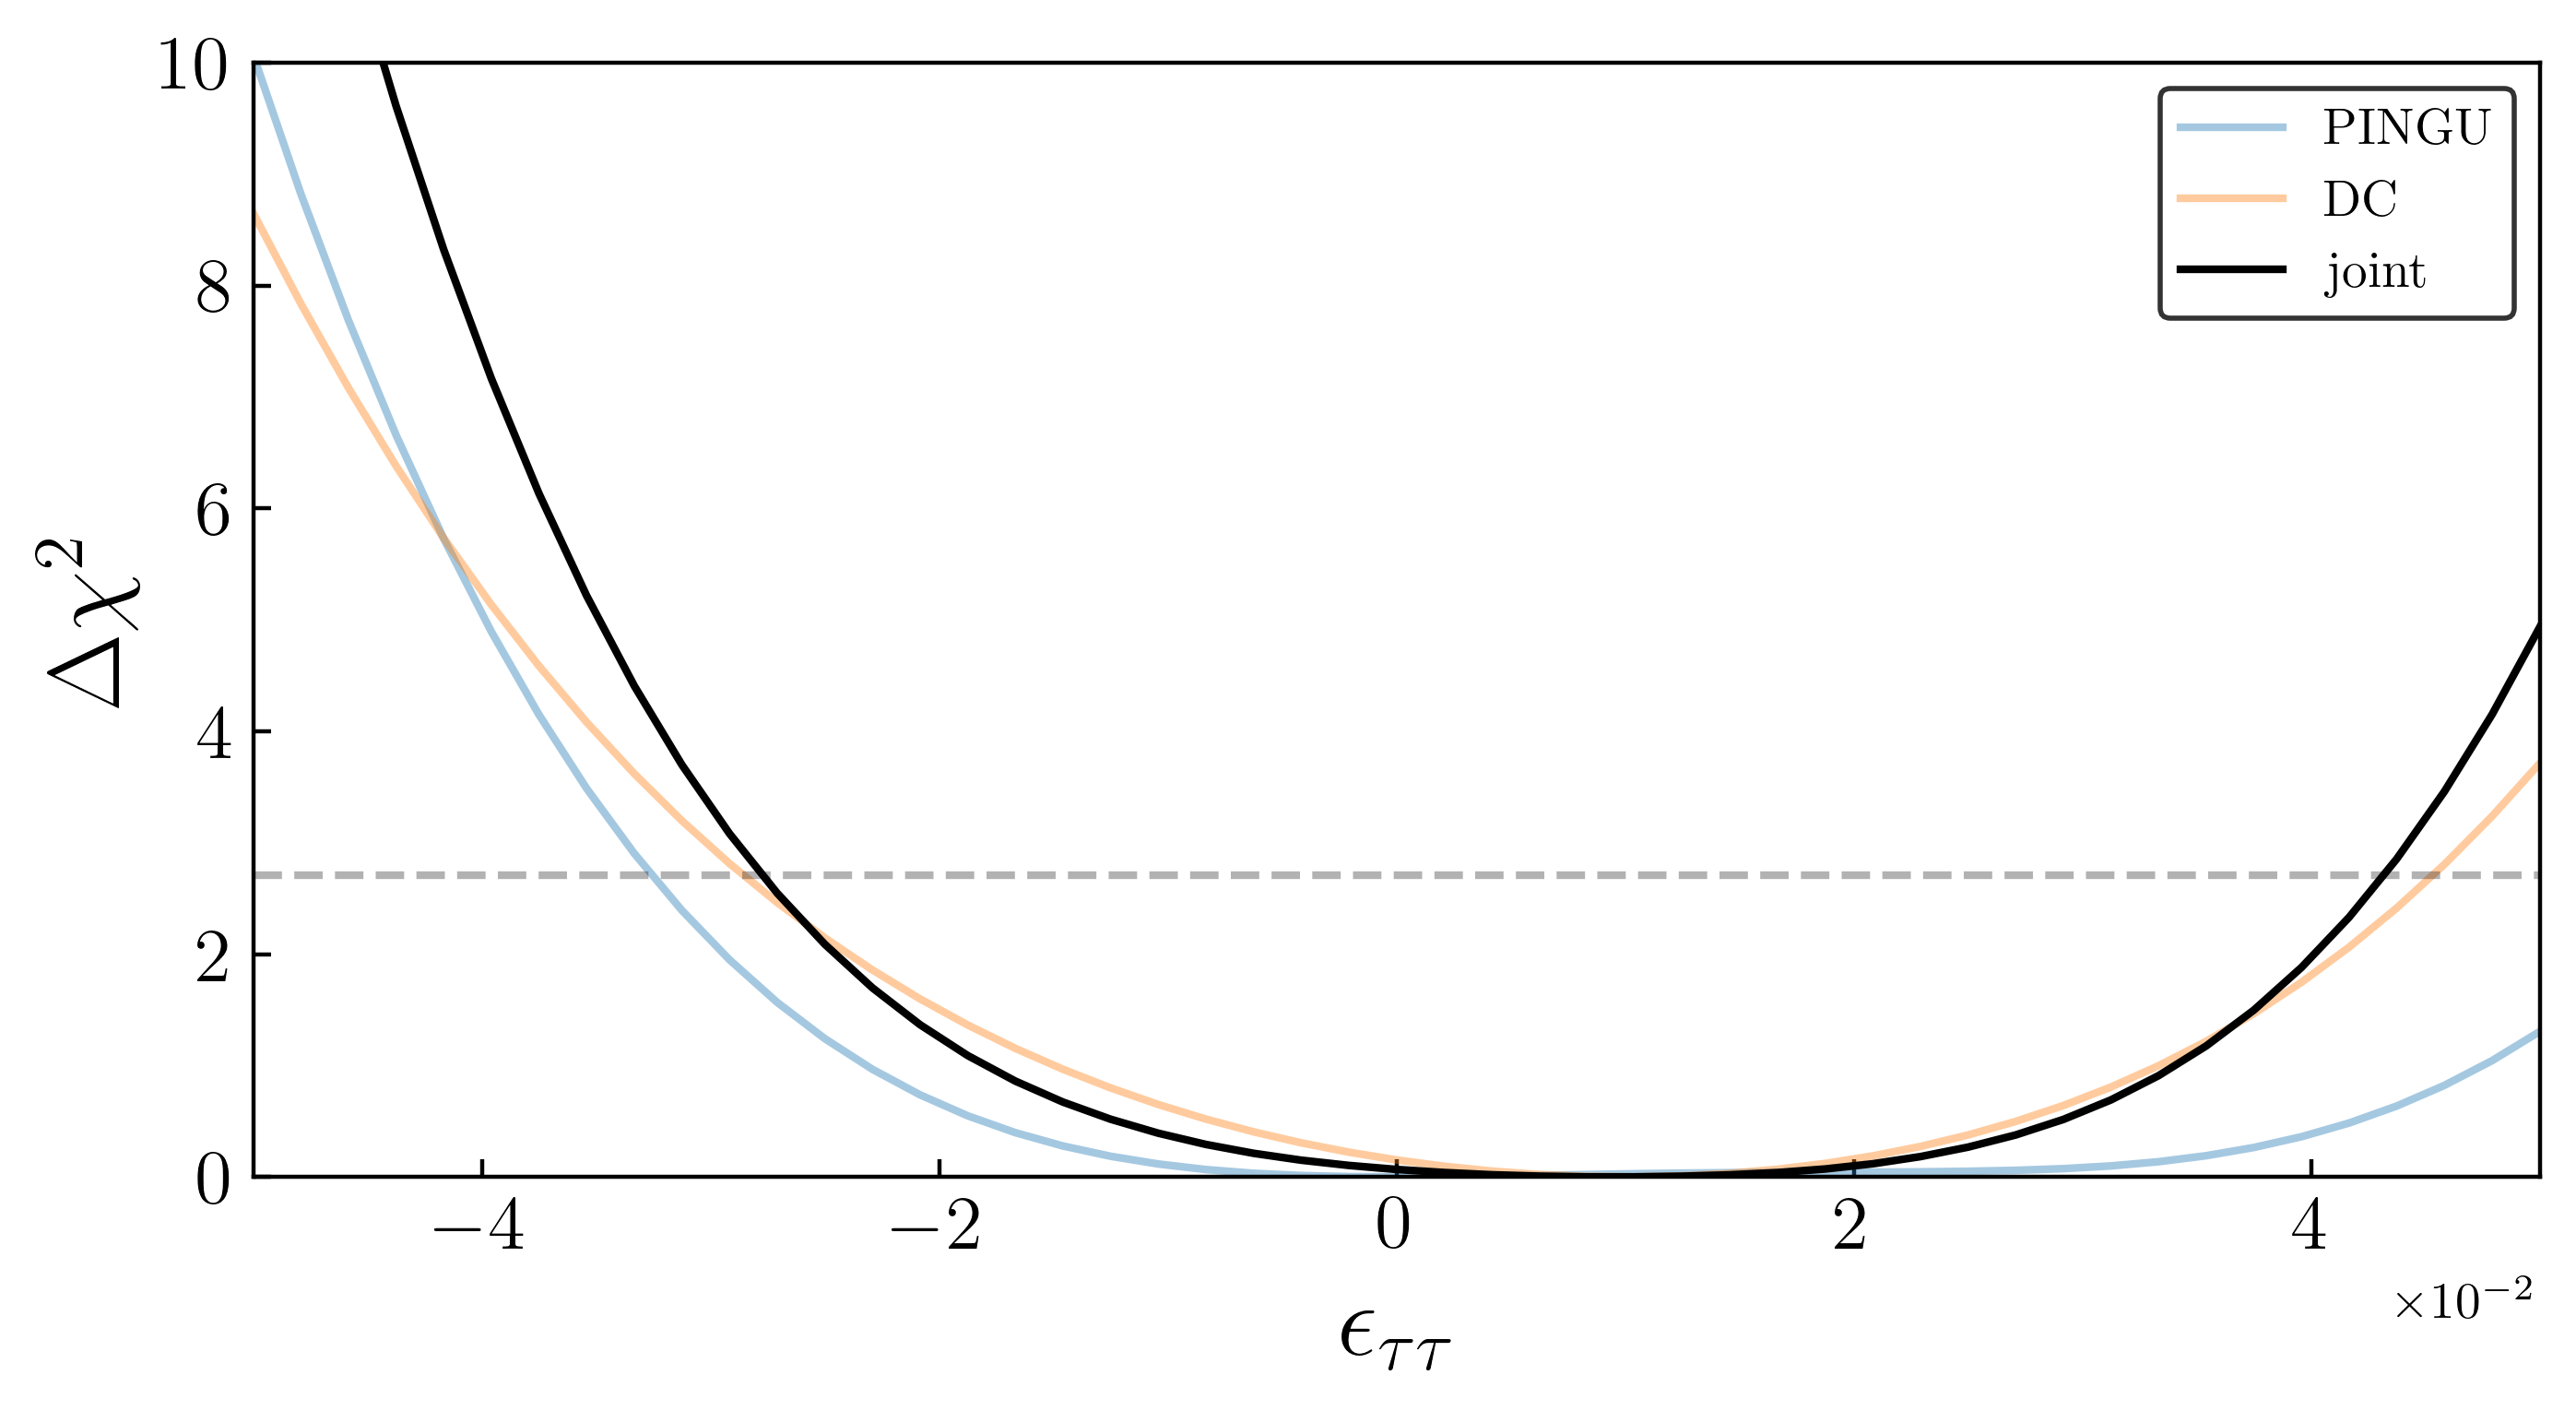

In [35]:
D_chisq  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'ett', sigma_a,sigma_b, f_DC)

P_chisq = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'ett', sigma_a,sigma_b, f_PINGU)

finer_e_range = np.linspace(ett_range.min(),ett_range.max(),49)


P_interpolated_chisq_ett= splev(finer_e_range,splrep(ett_range, P_chisq))
P_interpolated_ett = P_interpolated_chisq_ett - P_interpolated_chisq_ett.min()

D_interpolated_chisq_ett= splev(finer_e_range,splrep(ett_range, D_chisq))
D_interpolated_ett = D_interpolated_chisq_ett - D_interpolated_chisq_ett.min()

PD_interpolated_chisq_ett= splev(finer_e_range,splrep(ett_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,:,PD_best_emt_index,PD_best_eem_index,PD_best_eet_index]))
PD_interpolated_ett = PD_interpolated_chisq_ett - PD_interpolated_chisq_ett.min()


fig,ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(finer_e_range, P_interpolated_ett,label='PINGU', alpha=0.4)
ax.plot(finer_e_range, D_interpolated_ett,label='DC', alpha=0.4)
ax.plot(finer_e_range, PD_interpolated_ett,label='joint', color='k')

ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

ax.set_ylim(bottom=0, top=10)
ax.set_xlim(ett_range.min(),ett_range.max())
ax.set_xlabel(r'$\epsilon_{\tau\tau}$', fontsize=20)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
leg=plt.legend()
leg.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', direction='in', which='both')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#save(fig, 'joint_3D_ett')

In [63]:
D_chisq  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'emt', sigma_a,sigma_b, f_DC)

P_chisq = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'emt', sigma_a,sigma_b, f_PINGU)

finer_e_range = np.linspace(emt_range.min(),emt_range.max(),49)


P_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, P_chisq))
P_interpolated_emt = P_interpolated_chisq_emt - P_interpolated_chisq_emt.min()

D_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, D_chisq))
D_interpolated_emt = D_interpolated_chisq_emt - D_interpolated_chisq_emt.min()

PD_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,:,PD_best_eem_index,PD_best_eet_index]))
PD_interpolated_emt = PD_interpolated_chisq_emt - PD_interpolated_chisq_emt.min()

PID_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, PID_chisq[PID_best_dm31_index,PID_best_th23_index,PID_best_ett_index,:,PID_best_eem_index,PID_best_eet_index]))
PID_interpolated_emt = PID_interpolated_chisq_emt - PID_interpolated_chisq_emt.min()

ID_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, ID_chisq[ID_best_dm31_index,ID_best_th23_index,ID_best_ett_index,:,ID_best_eem_index,ID_best_eet_index]))
ID_interpolated_emt = ID_interpolated_chisq_emt - ID_interpolated_chisq_emt.min()

if f_PINGU == 0:
    I_interpolated_emt_best = I_interpolated_emt
    P_interpolated_emt_best = P_interpolated_emt
    ID_interpolated_emt_best = ID_interpolated_emt
    PID_interpolated_emt_best = PID_interpolated_emt
else:
    I_interpolated_emt_worst = I_interpolated_emt
    P_interpolated_emt_worst = P_interpolated_emt
    ID_interpolated_emt_worst = ID_interpolated_emt
    PID_interpolated_emt_worst = PID_interpolated_emt

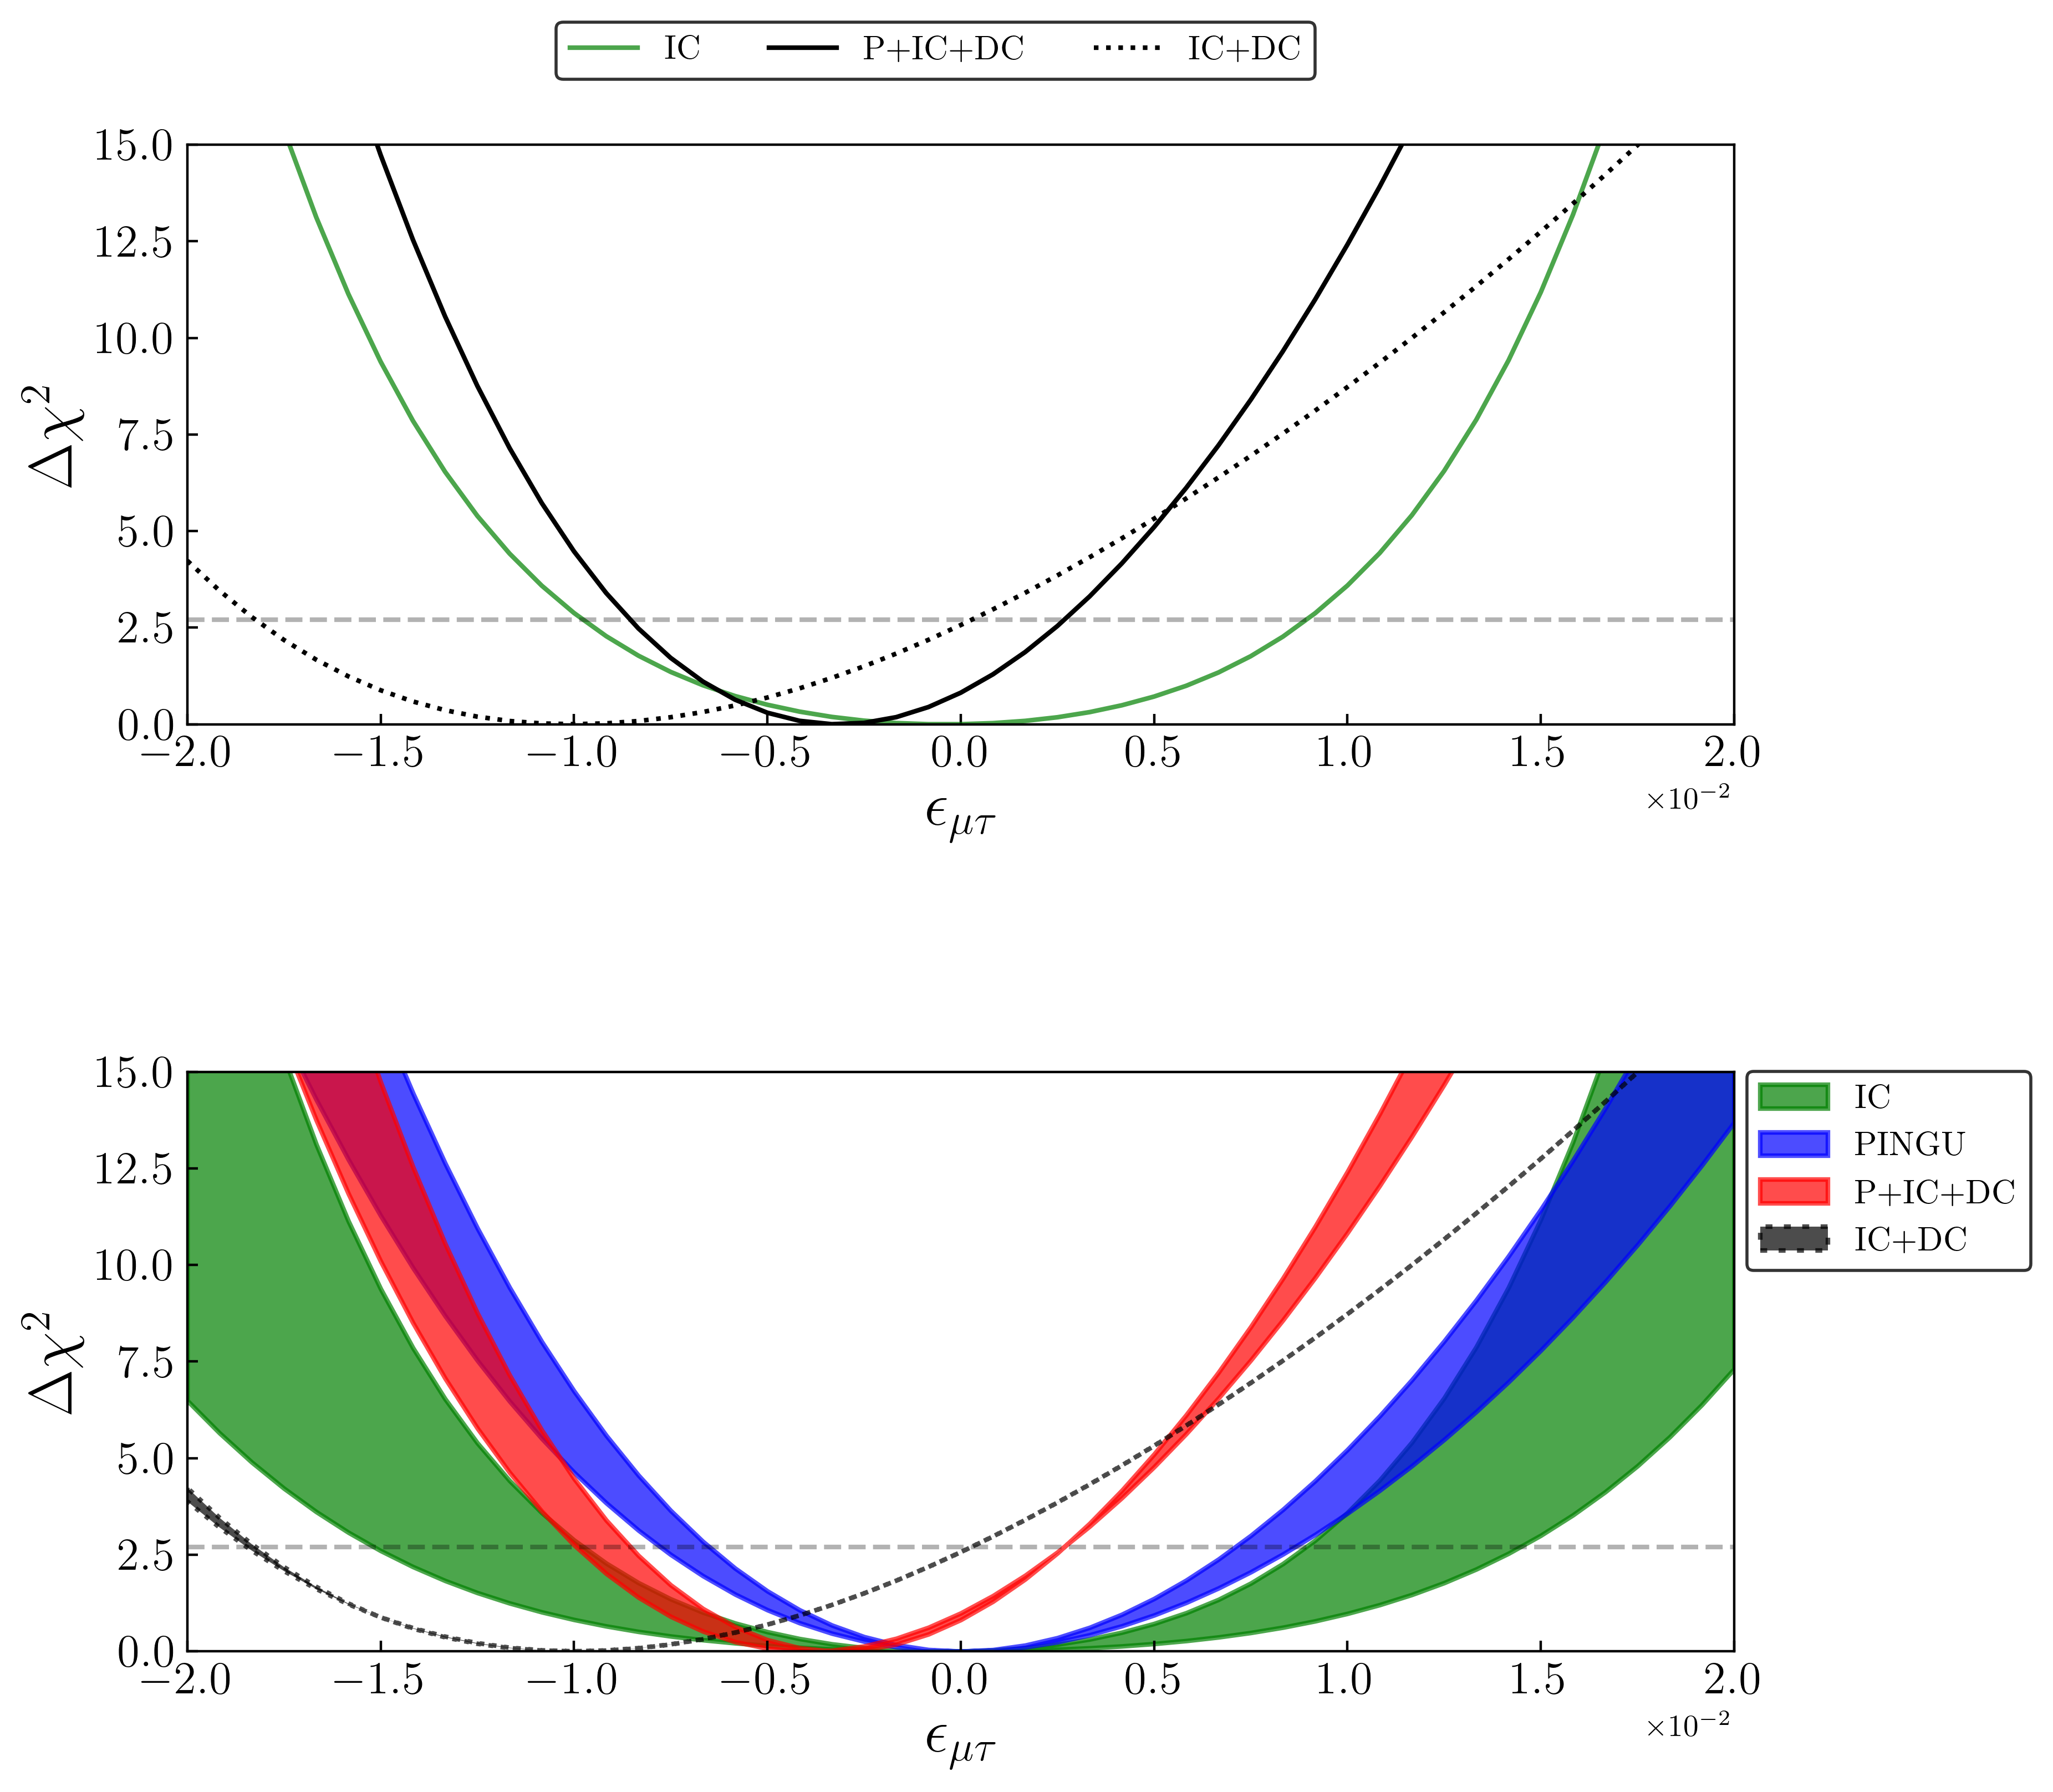

In [71]:
fig,ax = plt.subplots(2,1,figsize=(9,9))

ax[0].plot(finer_e_range, I_interpolated_emt_best,label='IC', alpha=0.7, lw=1.5, c='g')
ax[0].plot(finer_e_range, PID_interpolated_emt_best,label='P+IC+DC', c='k', lw=1.5)
ax[0].plot(finer_e_range, ID_interpolated_emt_best,label='IC+DC', c='k', lw=1.5, ls=':')

ax[0].axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')


ax[0].set_ylim(bottom=0, top=15)
ax[0].set_xlim(left=-2e-2, right=2e-2)
ax[0].set_xlabel(r'$\epsilon_{\mu\tau}$', fontsize=20)
ax[0].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[0].tick_params(labelsize=15)
handles, labels = ax[0].get_legend_handles_labels()
leg= fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.95),fontsize=11)
leg.get_frame().set_edgecolor('k')
ax[0].tick_params(axis='both', direction='in', which='both')
ax[0].ticklabel_format(axis="x", style="sci", scilimits=(0,0))


ax[1].fill_between(finer_e_range, I_interpolated_emt_worst, I_interpolated_emt_best,label='IC ', alpha=0.7, lw=1.5, color='g')
ax[1].fill_between(finer_e_range, P_interpolated_emt_worst, P_interpolated_emt_best,label='PINGU', alpha=0.7, lw=1.5, color='b')
ax[1].fill_between(finer_e_range, PID_interpolated_emt_worst,PID_interpolated_emt_best, label='P+IC+DC', alpha=0.7, lw=1.5,color='k', hatch='//')
ax[1].fill_between(finer_e_range, ID_interpolated_emt_worst,ID_interpolated_emt_best,label='IC+DC', alpha=0.7, lw=1.5,color='k', ls='dotted')

ax[1].axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

ax[1].set_ylim(bottom=0, top=15)
ax[1].set_xlim(left=-2e-2, right=2e-2)
ax[1].set_xlabel(r'$\epsilon_{\mu\tau}$', fontsize=20)
ax[1].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[1].tick_params(labelsize=15)
handles, labels = ax[1].get_legend_handles_labels()
leg= ax[1].legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(1.1, 1.03),fontsize=11)
leg.get_frame().set_edgecolor('k')
ax[1].tick_params(axis='both', direction='in', which='both')
ax[1].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.subplots_adjust(hspace=0.6)
fig.savefig('article/figures/PID_3D_emt.pdf', bbox_inches="tight")
#from subprocess import call 
#_ = call('pdfcrop article/figures/PID_3D_emt.pdf article/figures/PID_3D_emt.pdf')

In [ ]:
cl_90_bounds_IC = splrep(emt_range, I_chisq[I_best_dm31_index,I_best_th23_index,:] - I_chisq[I_best_dm31_index,I_best_th23_index,:].min()- chi2.ppf(0.9,1))
three_sigma_bounds_IC = splrep(emt_range, I_chisq[I_best_dm31_index,I_best_th23_index,:] - I_chisq[I_best_dm31_index,I_best_th23_index,:].min()- chi2.ppf(0.9973,1))
print('IC', f_IC)
print(f'90CL: {sproot(cl_90_bounds_IC)}\n'+f'3sigma: {sproot(three_sigma_bounds_IC)}\n')

cl_90_bounds_PID = splrep(emt_range, PID_chisq[PID_best_dm31_index,PID_best_th23_index,0,:,0,0] - PID_chisq[PID_best_dm31_index,PID_best_th23_index,0,:,0,0].min()- chi2.ppf(0.9,1))
three_sigma_bounds_PID = splrep(emt_range, PID_chisq[PID_best_dm31_index,PID_best_th23_index,0,:,0,0] - PID_chisq[PID_best_dm31_index,PID_best_th23_index,0,:,0,0].min()- chi2.ppf(0.9973,1))
print('PID', f_PINGU, f_IC)
print(f'90CL: {sproot(cl_90_bounds_PID)}\n'+f'3sigma: {sproot(three_sigma_bounds_PID)}\n')

cl_90_bounds_ID = splrep(emt_range, ID_chisq[ID_best_dm31_index,ID_best_th23_index,0,:,0,0] - ID_chisq[ID_best_dm31_index,ID_best_th23_index,0,:,0,0].min()- chi2.ppf(0.9,1))
three_sigma_bounds_ID = splrep(emt_range, ID_chisq[ID_best_dm31_index,ID_best_th23_index,0,:,0,0] - ID_chisq[ID_best_dm31_index,ID_best_th23_index,0,:,0,0].min()- chi2.ppf(0.9973,1))
print('ID', f_IC)
print(f'90CL: {sproot(cl_90_bounds_ID)}\n'+f'3sigma: {sproot(three_sigma_bounds_ID)}\n')

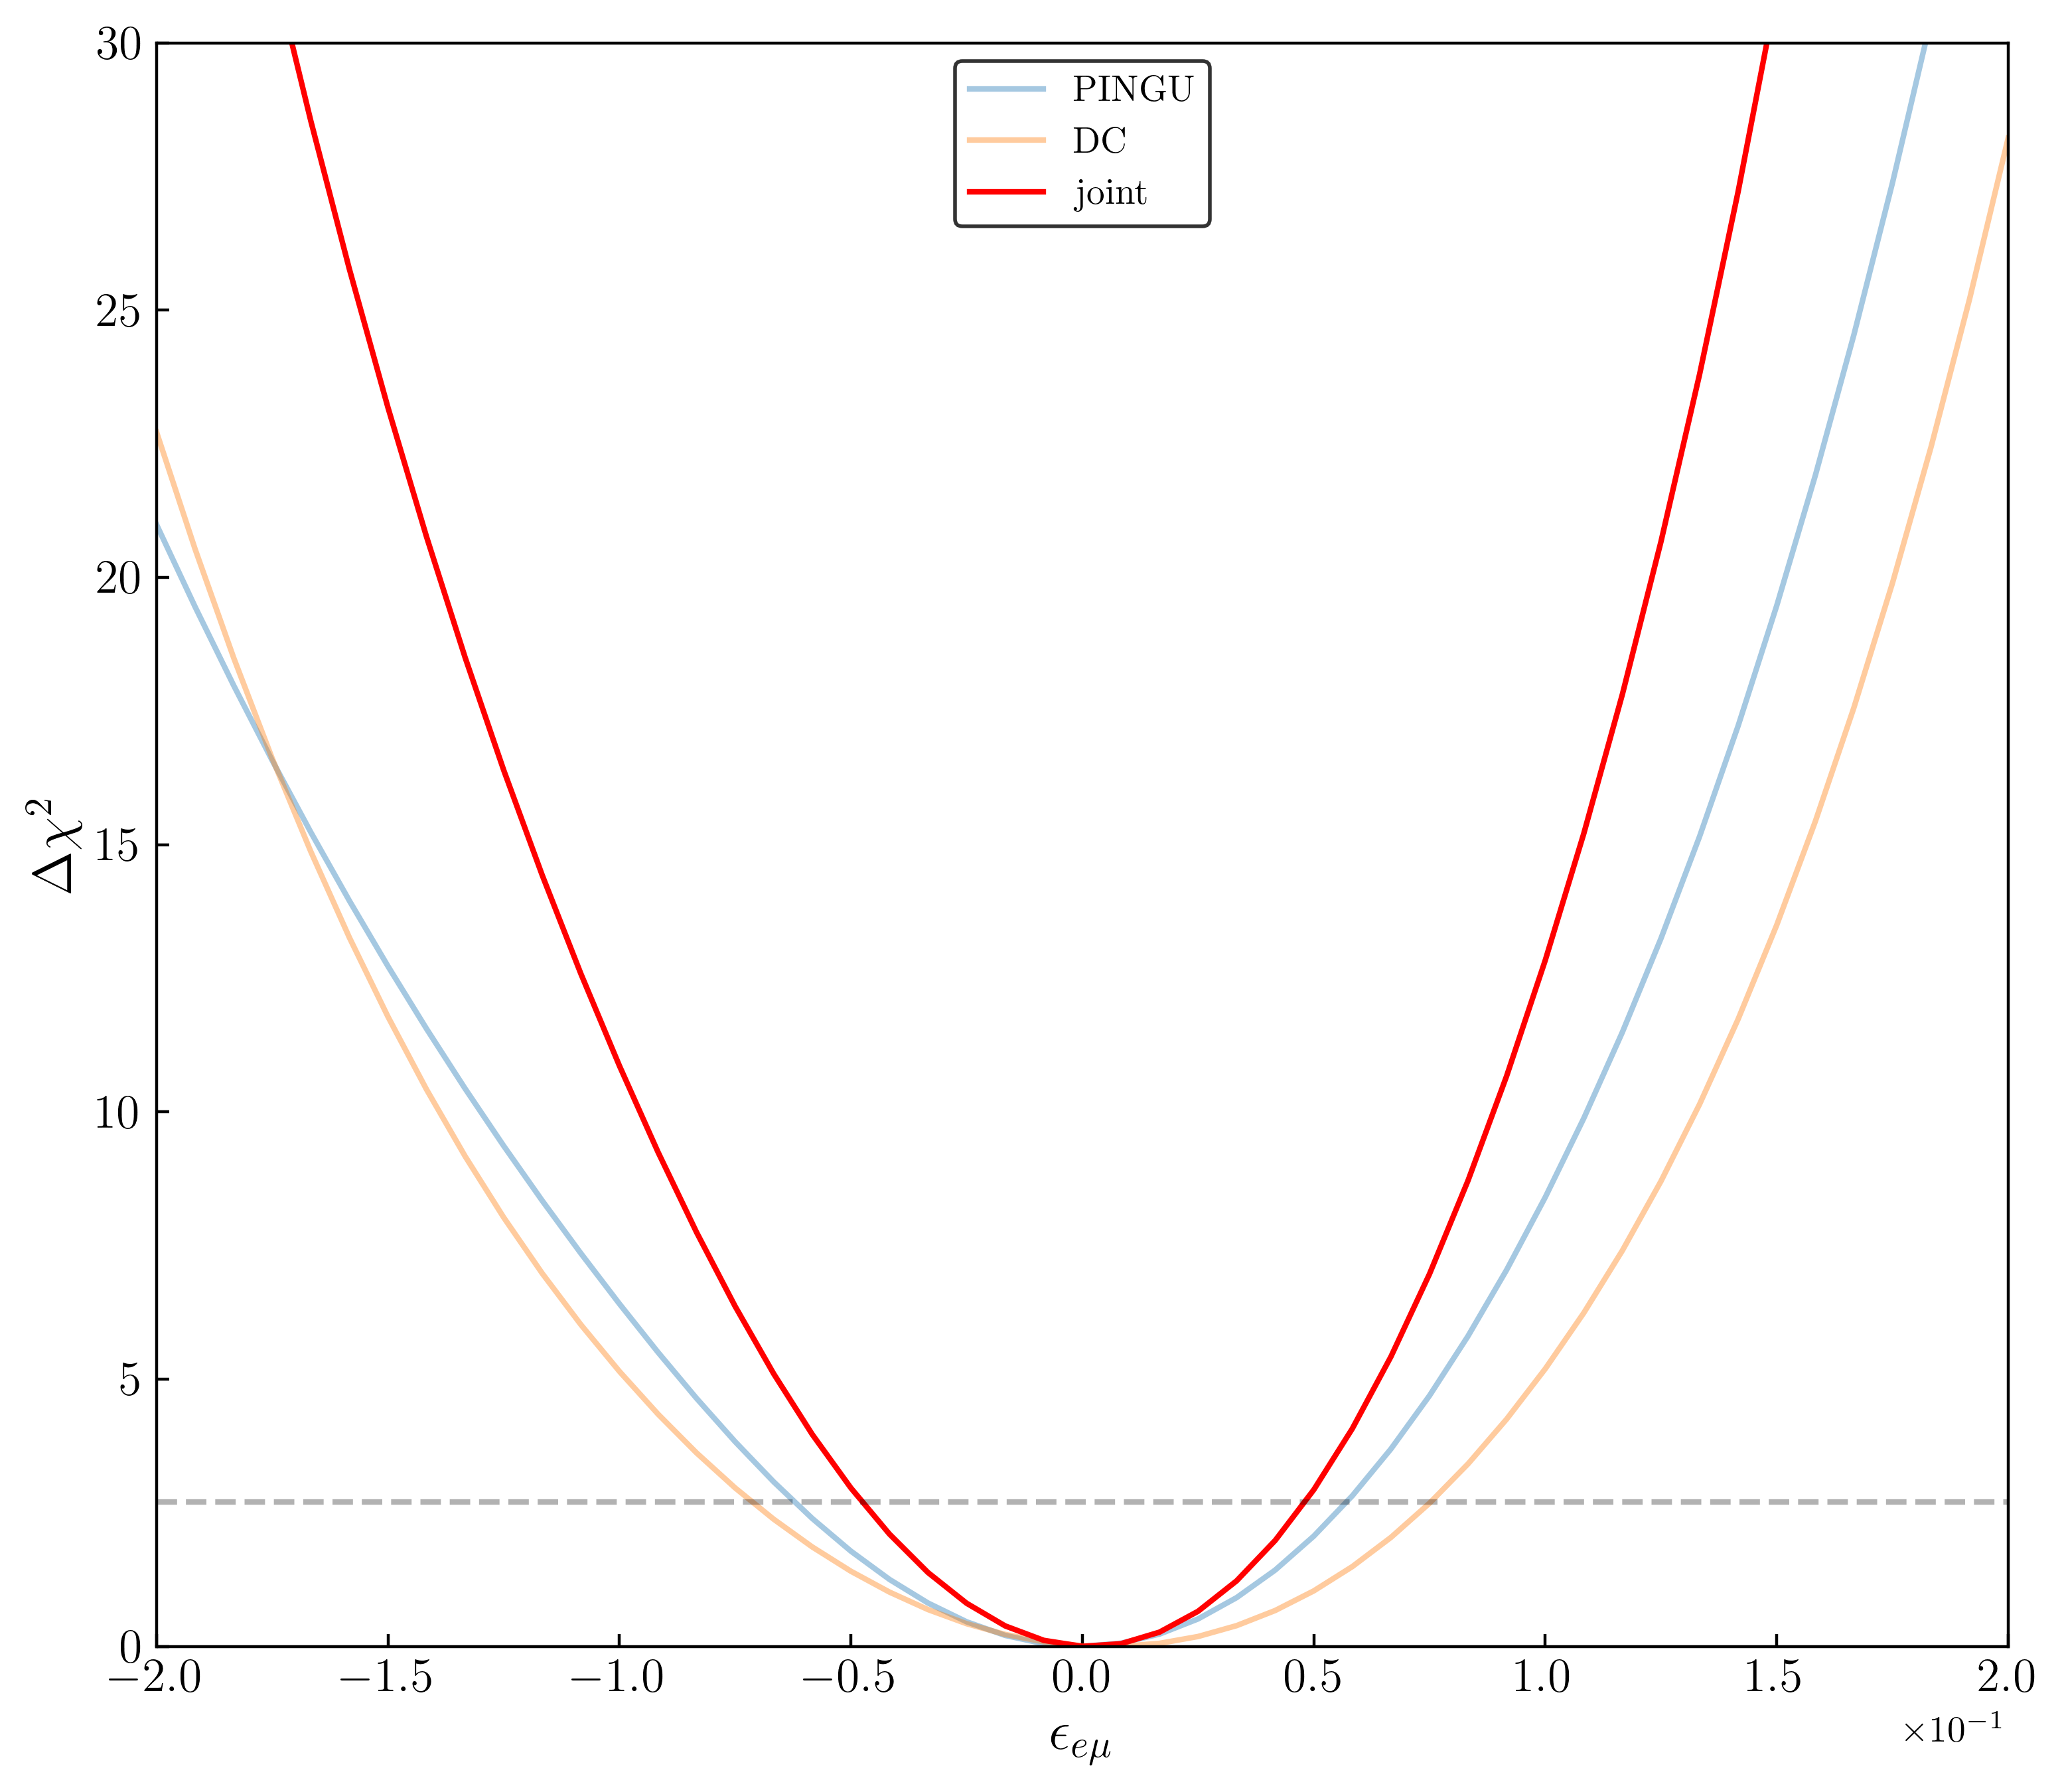

In [47]:
fig,ax = plt.subplots(1,1,figsize=(9,8))
D_chisq  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'eem', sigma_a,sigma_b, f_DC)

P_chisq = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'eem', sigma_a,sigma_b, f_PINGU)

finer_e_range = np.linspace(eem_range.min(),eem_range.max(),49)


P_interpolated_chisq_eem= splev(finer_e_range,splrep(eem_range, P_chisq))
P_interpolated_eem = P_interpolated_chisq_eem - P_interpolated_chisq_eem.min()

D_interpolated_chisq_eem= splev(finer_e_range,splrep(eem_range, D_chisq))
D_interpolated_eem = D_interpolated_chisq_eem - D_interpolated_chisq_eem.min()

PD_interpolated_chisq_eem= splev(finer_e_range,splrep(eem_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,PD_best_emt_index,:,PD_best_eet_index]))
PD_interpolated_eem = PD_interpolated_chisq_eem - PD_interpolated_chisq_eem.min()

ax.plot(finer_e_range, P_interpolated_eem,label='PINGU', alpha=0.4)
ax.plot(finer_e_range, D_interpolated_eem,label='DC', alpha=0.4)
ax.plot(finer_e_range, PD_interpolated_eem,label='joint', color='red')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

ax.set_ylim(bottom=0, top =30)
ax.set_xlim(-2e-1,2e-1)
#plt.xlim((emt_range.min(), emt_range.max()))
ax.set_xlabel(r'$\epsilon_{e\mu}$', fontsize=15)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=15)
ax.tick_params(labelsize=13)
leg = plt.legend()
leg.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', direction='in', which='both')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#save(fig, 'joint_3D_eem')

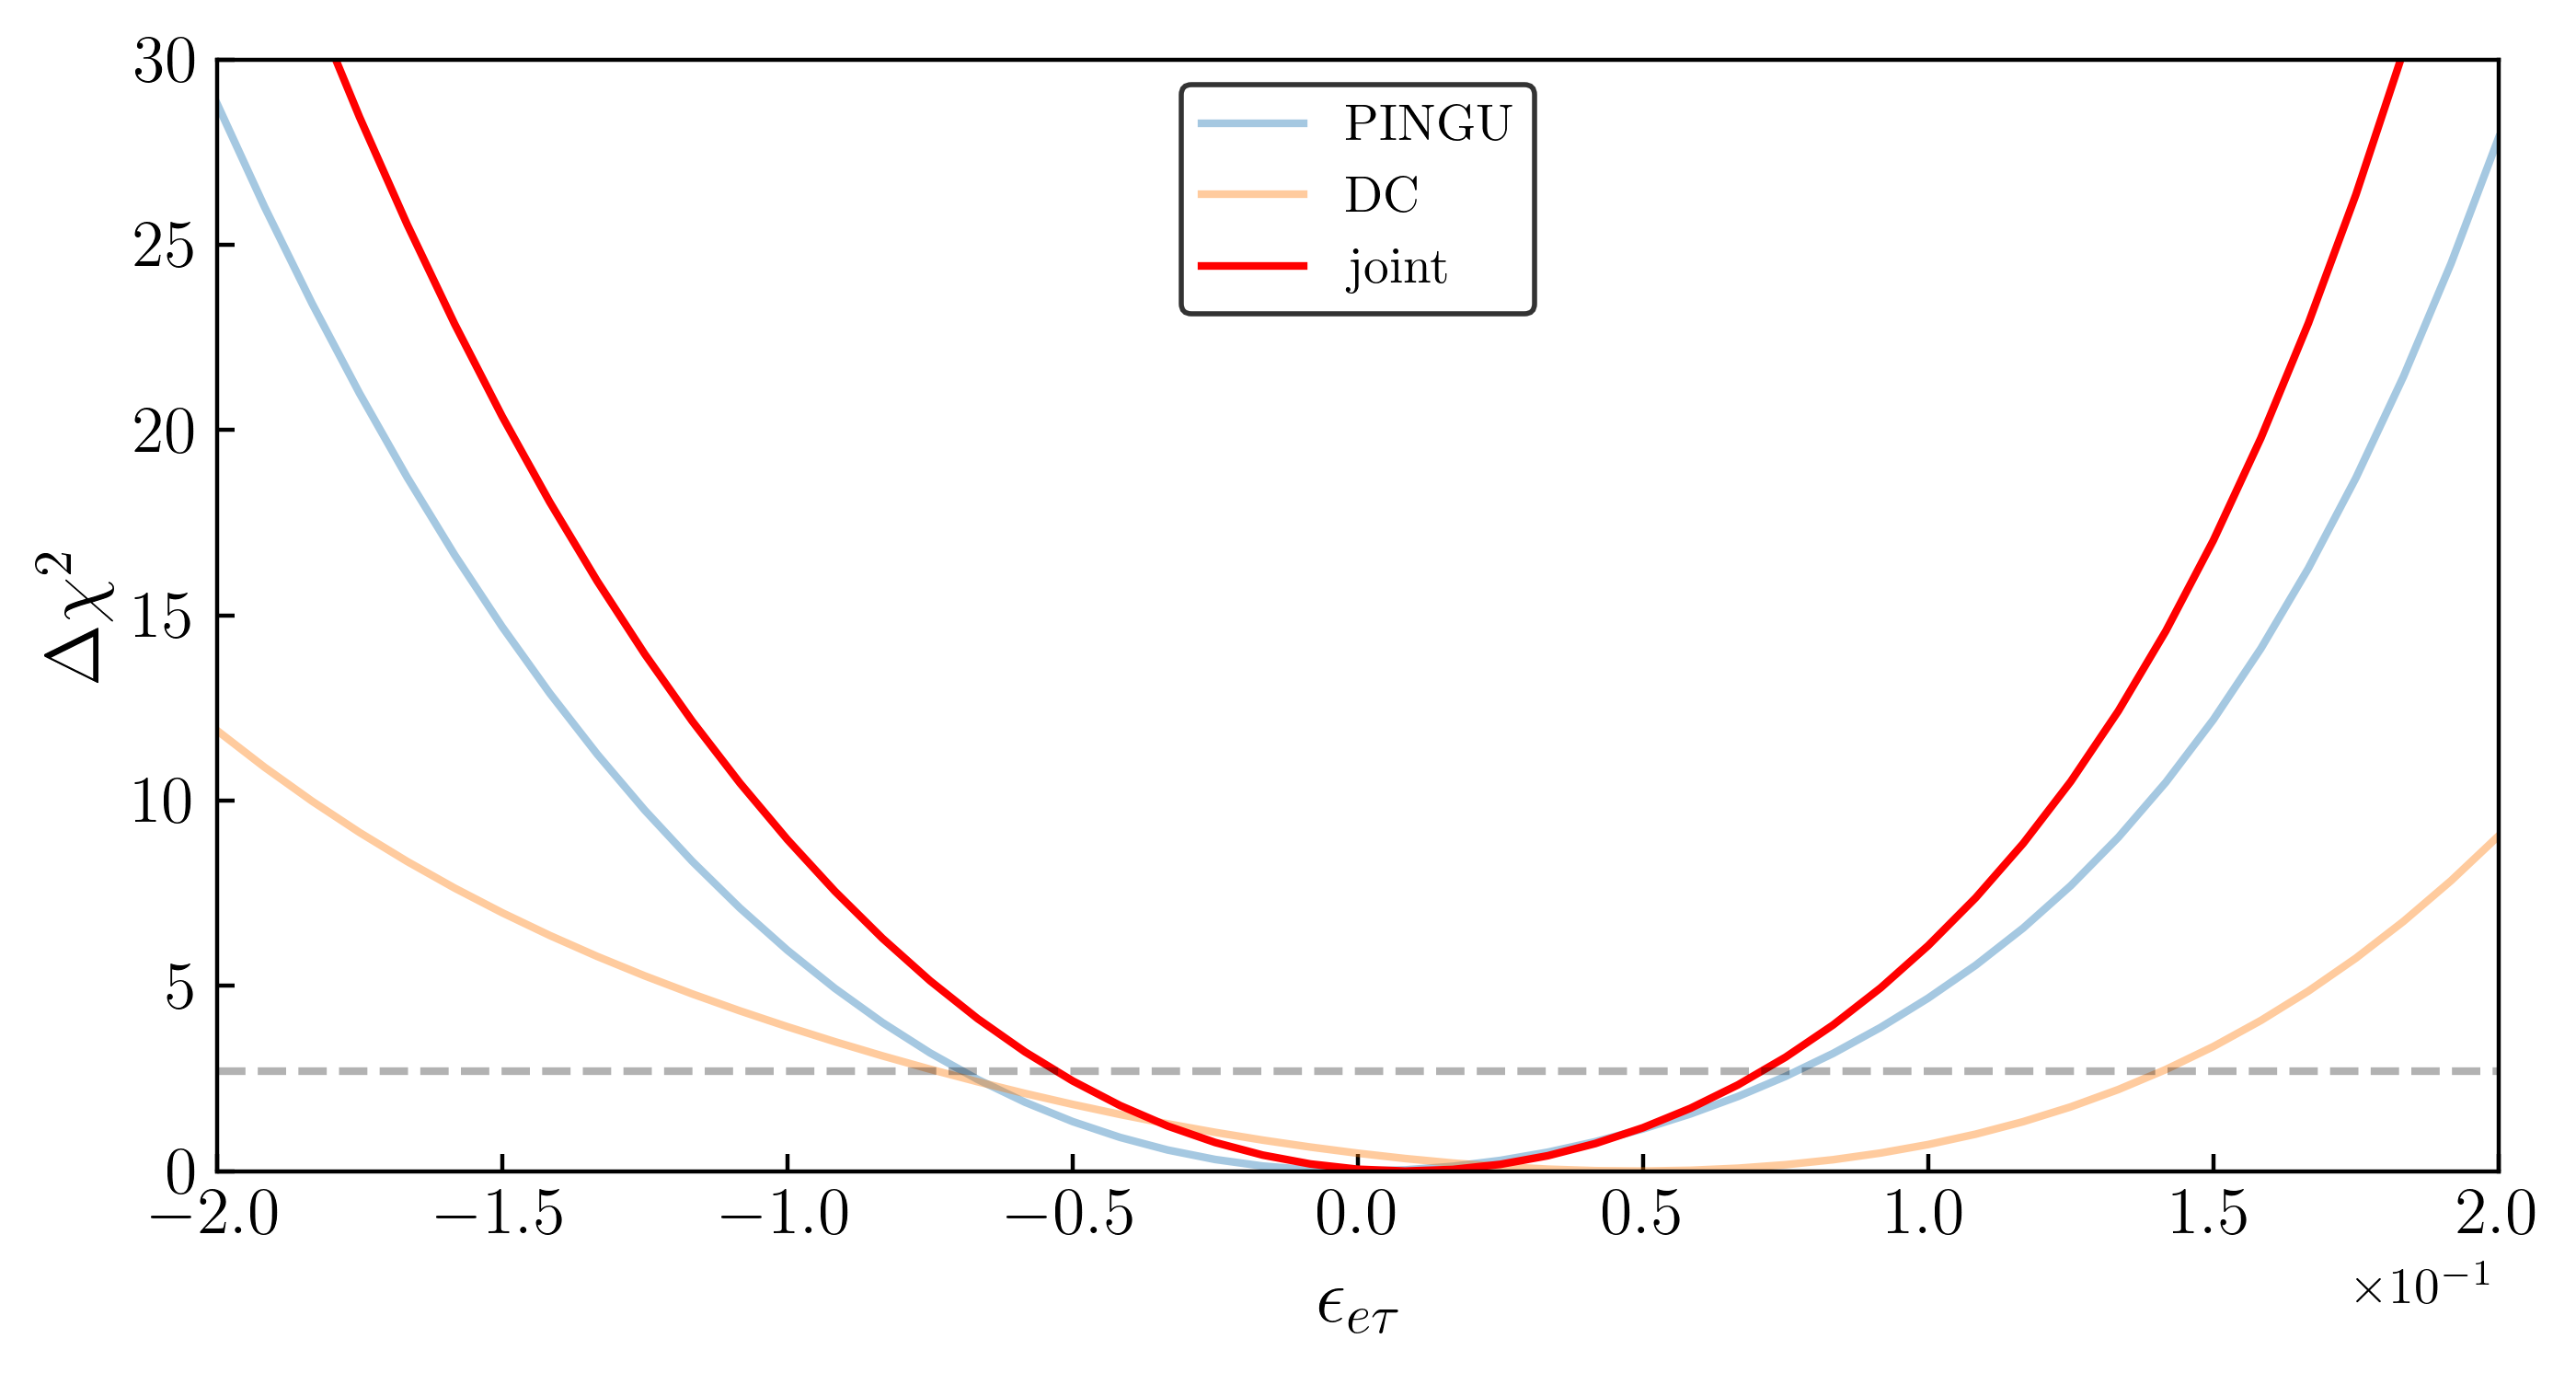

In [53]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
D_chisq  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'eet', sigma_a,sigma_b, f_DC)

P_chisq = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'eet', sigma_a,sigma_b, f_PINGU)

finer_e_range = np.linspace(eet_range.min(),eet_range.max(),49)


P_interpolated_chisq_eet= splev(finer_e_range,splrep(eet_range, P_chisq))
P_interpolated_eet = P_interpolated_chisq_eet - P_interpolated_chisq_eet.min()

D_interpolated_chisq_eet= splev(finer_e_range,splrep(eet_range, D_chisq))
D_interpolated_eet = D_interpolated_chisq_eet - D_interpolated_chisq_eet.min()

PD_interpolated_chisq_eet= splev(finer_e_range,splrep(eet_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,PD_best_emt_index,PD_best_eem_index,:]))
PD_interpolated_eet = PD_interpolated_chisq_eet - PD_interpolated_chisq_eet.min()

ax.plot(finer_e_range, P_interpolated_eet,label='PINGU', alpha=0.4)
ax.plot(finer_e_range, D_interpolated_eet,label='DC', alpha=0.4)
ax.plot(finer_e_range, PD_interpolated_eet,label='joint', color='red')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

ax.set_ylim(bottom=0, top =30)
ax.set_xlim(-2e-1,2e-1)
#plt.xlim((emt_range.min(), emt_range.max()))
ax.set_xlabel(r'$\epsilon_{e\tau}$', fontsize=15)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=15)
ax.tick_params(labelsize=13)
leg = plt.legend()
leg.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', direction='in', which='both')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#save(fig, 'joint_3D_eet')

<ipython-input-61-489f2f5cb7c2>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_xticklabels(labels=np.round(emt_range,3))
<ipython-input-61-489f2f5cb7c2>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_yticklabels(labels=np.round(emm_range,3))


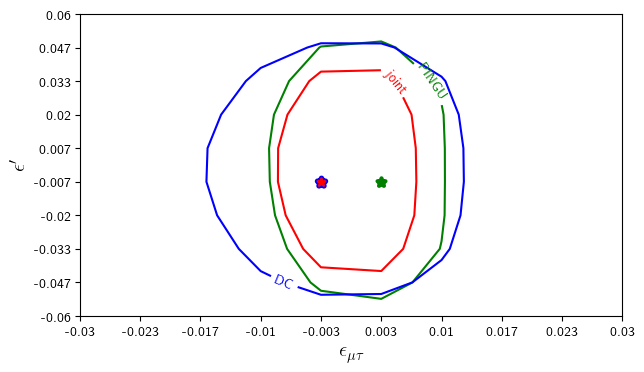

In [61]:
sandhya_emt = (-0.0043,0.0047)
sandhya_emm = (-0.03,0.017)

PINGU_deltachi_reshaped = PINGU_deltachi.reshape((len(emm_range), len(emt_range)))
DC_deltachi_reshaped = DC_deltachi.reshape((len(emm_range), len(emt_range)))
joint_deltachi_reshaped = (chibar - chibar.min()).reshape((len(emm_range), len(emt_range)))

best_fit_coords_PINGU = np.unravel_index(best_fit_index_PINGU,(len(emm_range),len(emt_range)))
best_fit_coords_DC = np.unravel_index(best_fit_index_DC,(len(emm_range),len(emt_range)))

best_fit_index_joint = np.argmin(joint_deltachi_reshaped)
best_fit_coords_joint = np.unravel_index(best_fit_index_joint,(len(emm_range),len(emt_range)))

fig, ax = plt.subplots(1,1, figsize=(7,4))
PINGU = ax.contour(PINGU_deltachi_reshaped.T,levels = [chi2.ppf(q=0.9, df = 2)], colors='green')
DC = ax.contour(DC_deltachi_reshaped.T,levels = [chi2.ppf(q=0.9, df = 2)],colors='blue')
joint = ax.contour(joint_deltachi_reshaped.T,levels = [chi2.ppf(q=0.9, df = 2)],colors='red')

ax.scatter(best_fit_coords_PINGU[0],best_fit_coords_PINGU[1], marker='*', color='green',lw=3)
ax.scatter(best_fit_coords_DC[0],best_fit_coords_DC[1], marker='*', color='blue', lw=4)
ax.scatter(best_fit_coords_joint[0],best_fit_coords_joint[1], marker='*', color='red', lw=1.5)
_=ax.set_xticklabels(labels=np.round(emt_range,3))
_=ax.set_yticklabels(labels=np.round(emm_range,3))
ax.set_xlabel(r'$\epsilon_{\mu\tau}$', fontsize=15)
ax.set_ylabel(r'$\epsilon^\prime$', fontsize=15)


fmt_PINGU = {}
strs = ['PINGU']#,'f = 5 \%']
for l, s in zip(PINGU.levels, strs):
    fmt_PINGU[l] = s

fmt_DC = {}
strs = ['DC']
for l, s in zip(DC.levels, strs):
    fmt_DC[l] = s

fmt_joint = {}
strs = ['joint']
for l, s in zip(DC.levels, strs):
    fmt_joint[l] = s

ax.clabel(PINGU, PINGU.levels, inline=True, fmt=fmt_PINGU, fontsize=10)
ax.clabel(DC, DC.levels, inline=True, fmt=fmt_DC, fontsize=10)
ax.clabel(joint, joint.levels, inline=True, fmt=fmt_joint, fontsize=10)
fig.savefig('latex/article/figures/emm_emp_contour.pdf')
from subprocess import call 
_ = call('pdfcrop latex/article/figures/emm_emp_contour.pdf latex/article/figures/emm_emp_contour.pdf')

hard-coded nsi_ranges
PINGU 0
$\epsilon_{\tau\tau}$
90CL: [-0.0326]
3sigma: [-0.0482]

DC
$\epsilon_{\tau\tau}$
90CL: [-0.0285  0.0453]
3sigma: []

joint
$\epsilon_{\tau\tau}$
90CL: [-0.0277  0.0432]
3sigma: [-0.0428]

PINGU 0
$\epsilon_{\mu\tau}$
90CL: [-0.0065  0.0071]
3sigma: [-0.0114  0.0133]

DC
$\epsilon_{\mu\tau}$
90CL: [-0.0154  0.0048]
3sigma: [0.0152]

joint
$\epsilon_{\mu\tau}$
90CL: [-0.0067  0.0049]
3sigma: [-0.0109  0.0101]

PINGU 0
$\epsilon_{e\mu}$
90CL: [-0.0623  0.0572]
3sigma: [-0.1221  0.1035]

DC
$\epsilon_{e\mu}$
90CL: [-0.0714  0.0753]
3sigma: [-0.1321  0.1268]

joint
$\epsilon_{e\mu}$
90CL: [-0.0476  0.0482]
3sigma: [-0.0903  0.0846]

PINGU 0
$\epsilon_{e\tau}$
90CL: [-0.0695  0.0771]
3sigma: [-0.1206  0.1333]

DC
$\epsilon_{e\tau}$
90CL: [-0.0739  0.1412]
3sigma: [-0.1736  0.1997]

joint
$\epsilon_{e\tau}$
90CL: [-0.053   0.0711]
3sigma: [-0.1003  0.1175]

<ipython-input-57-c3e01cb50135>:66: UserWarning: This figure was using constrained_layout, but that is inc

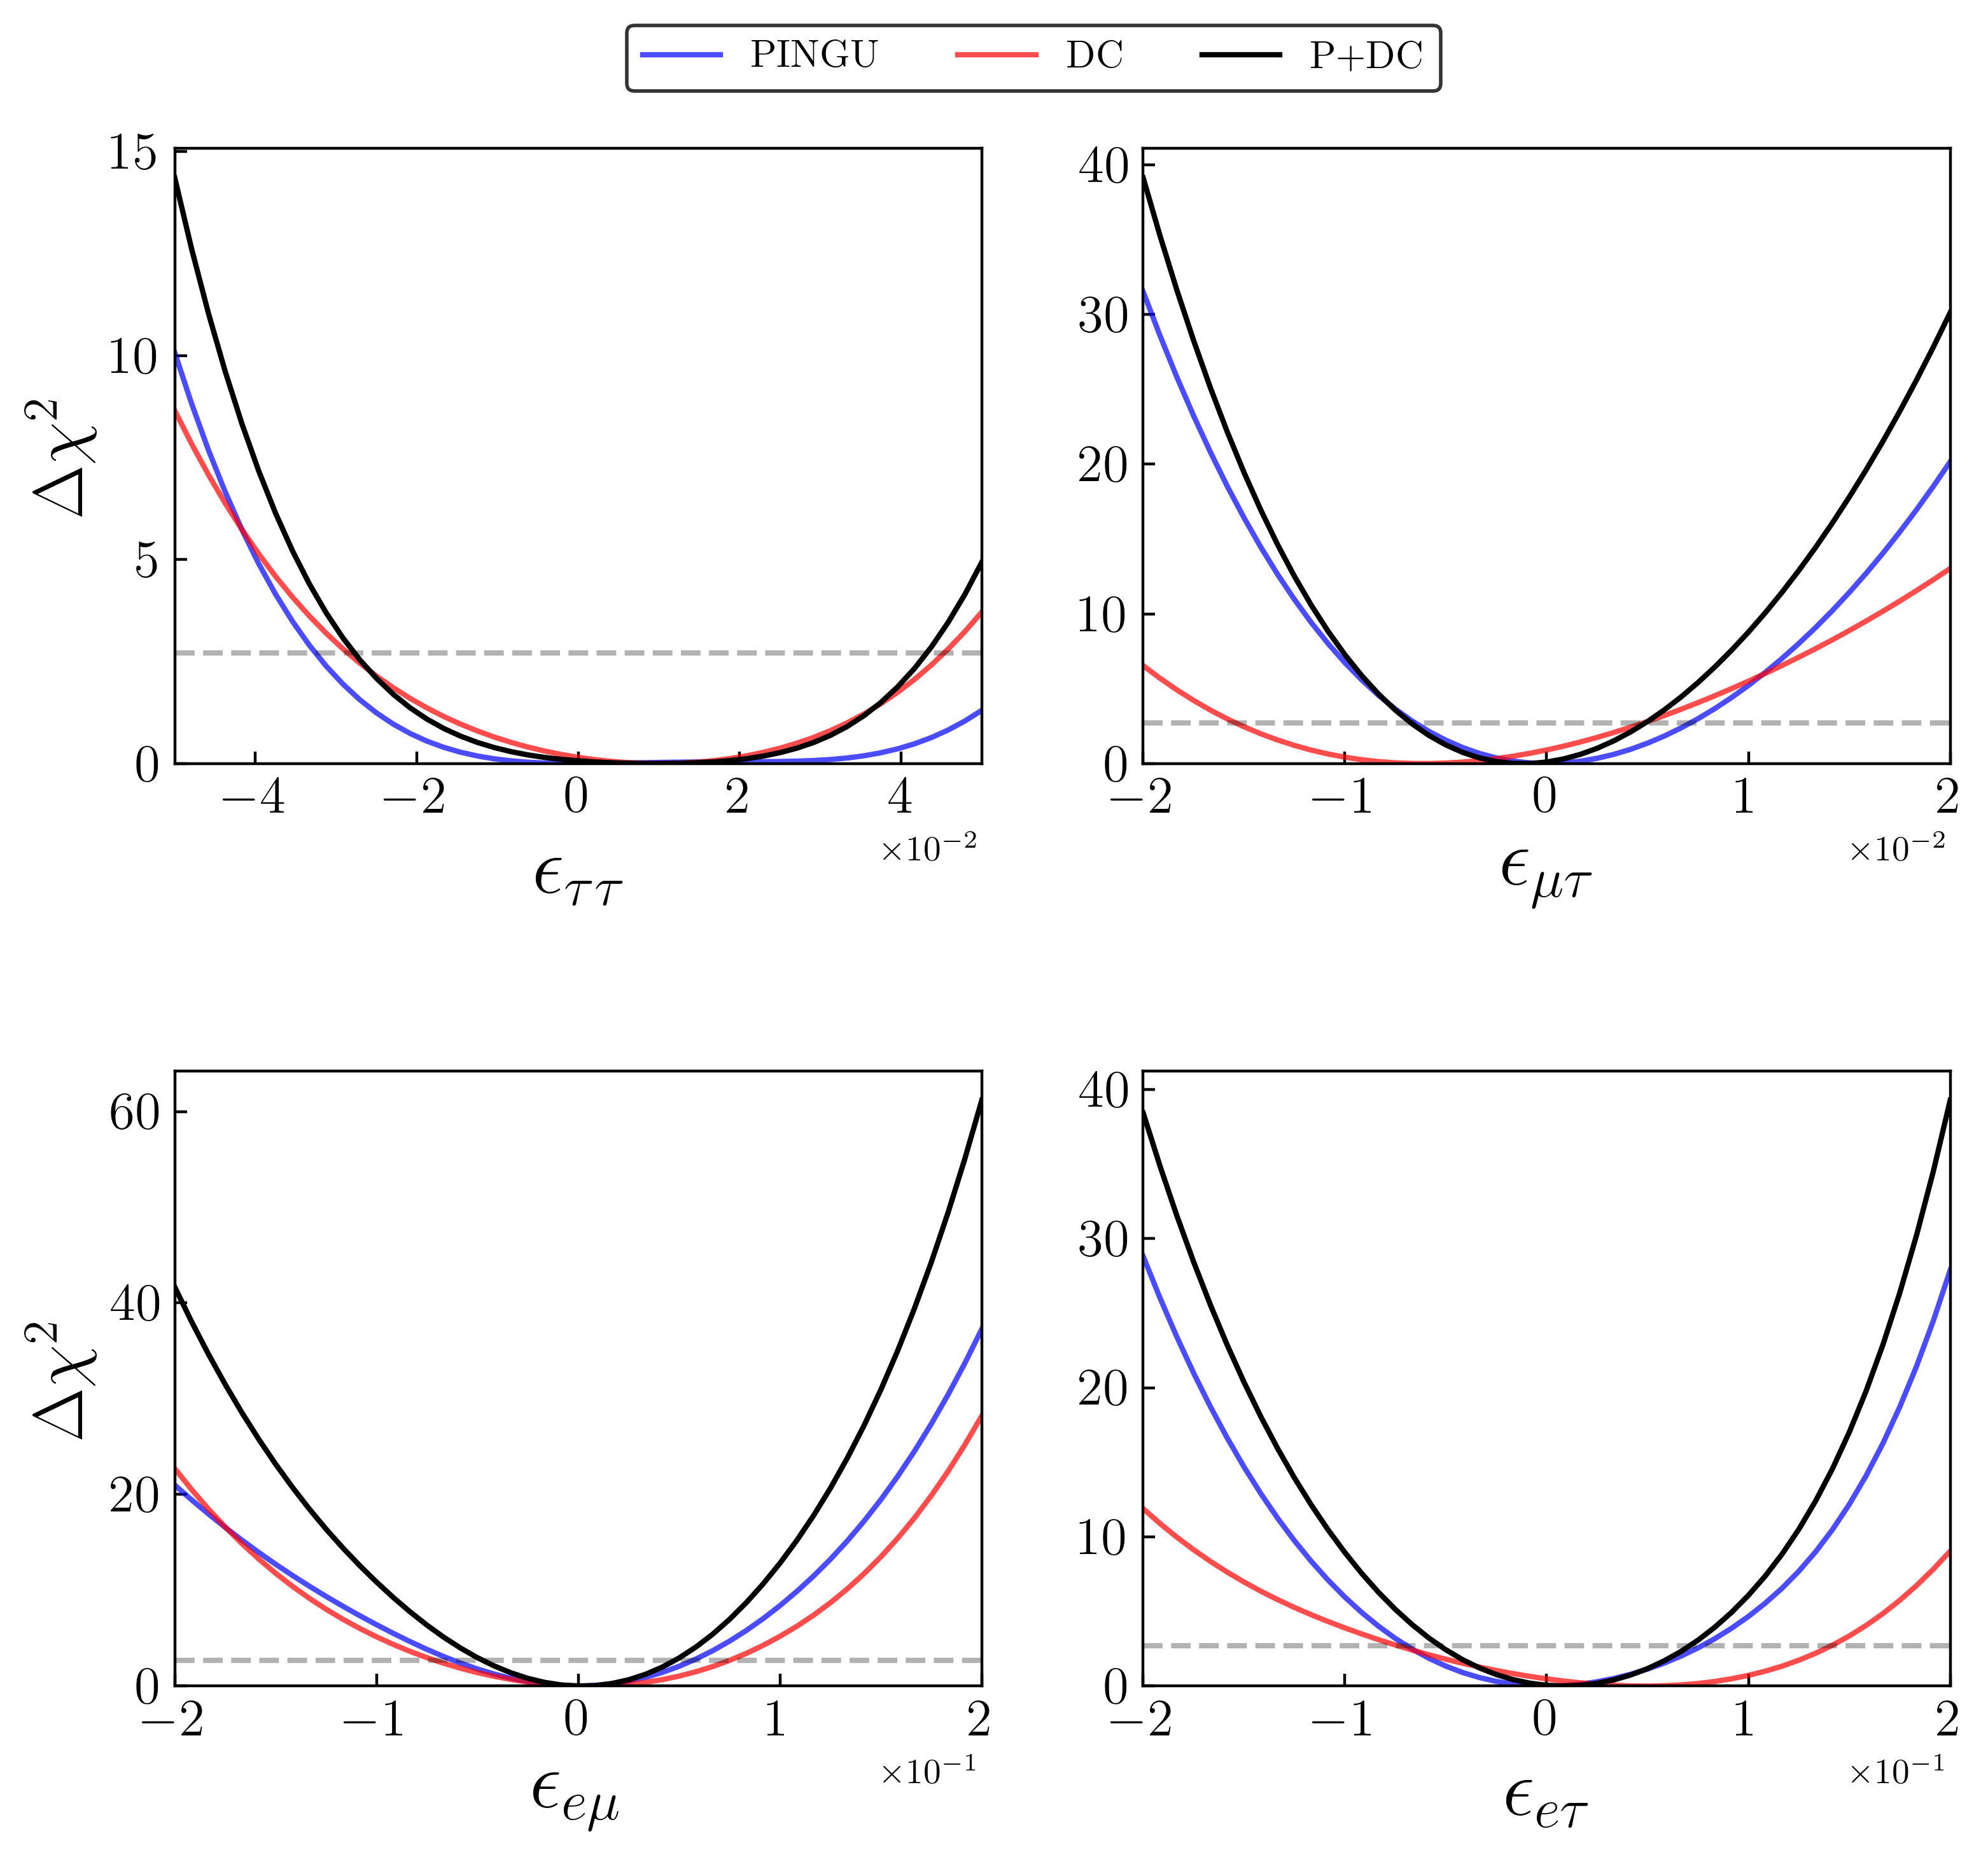

In [57]:
#DC_marg_NO = [DC_marginalized_ett,DC_marginalized_emt,DC_marginalized_eem,DC_marginalized_eet]
#PINGU_marg_NO = [PINGU_marginalized_ett,PINGU_marginalized_emt,PINGU_marginalized_eem,PINGU_marginalized_eet]
#joint_marg_NO = [joint_marginalized_ett,joint_marginalized_emt,joint_marginalized_eem,joint_marginalized_eet]
D_marg_NO = [D_interpolated_ett,D_interpolated_emt,D_interpolated_eem,D_interpolated_eet]
P_marg_NO = [P_interpolated_ett,P_interpolated_emt,P_interpolated_eem,P_interpolated_eet]
PD_marg_NO = [PD_interpolated_ett,PD_interpolated_emt,PD_interpolated_eem,PD_interpolated_eet]

nsi_param_range = [np.linspace(-5e-2,5e-2,9),np.linspace(-2e-2,2e-2,9), np.linspace(-2e-1,2e-1,9), np.linspace(-2e-1,2e-1,9)]

print('hard-coded nsi_ranges')
fig, ax = plt.subplots(2,2,figsize=(9,8), constrained_layout=True)
ax = ax.flatten()
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
xlabels = [r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$', r'$\epsilon_{e\tau}$']
demidovs =[demidov_ett, demidov_emt, demidov_eem, demidov_eet]
for i in range(4):
    finer_e_range = np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),49)
    #interpolated_PINGU = splev(np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),50),splrep(nsi_param_range[i], PINGU_marg_NO[i]))
    #interpolated_DC = splev(np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),50),splrep(nsi_param_range[i], DC_marg_NO[i]))
    #interpolated_joint = splev(np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),50),splrep(nsi_param_range[i], joint_marg_NO[i]))

    ax[i].plot(finer_e_range, P_marg_NO[i], label='PINGU', alpha=0.7, c='b', lw=1.5)
    ax[i].plot(finer_e_range, D_marg_NO[i], label='DC', alpha=0.7, c='r', lw=1.5)
    ax[i].plot(finer_e_range, PD_marg_NO[i], label='P+DC', color='k', lw=1.5)
    '''
    ax[i].plot(nsi_param_range[i], PINGU_marg_NO[i], label='PINGU', alpha=0.4, c='b', lw=1)
    ax[i].plot(nsi_param_range[i], DC_marg_NO[i], label='DC', alpha=0.4, c='g', lw=1)
    ax[i].plot(nsi_param_range[i], joint_marg_NO[i], label='Joint', color='k', lw=1)
    '''

    ax[i].axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

    #ax[i].axvline(demidovs[i][0], alpha=0.6,c='black', label=r'Demidov NO')
    #ax[i].axvline(demidovs[i][1], alpha=0.6,c='black')
    ax[i].set_ylim(bottom=0)
    ax[i].set_xlim((nsi_param_range[i].min(), nsi_param_range[i].max()))
    ax[i].set_xlabel(xlabels[i], fontsize=23)
    ax[i].tick_params(labelsize=15,axis='both', direction='in', which='both')
    ax[i].ticklabel_format(axis="x", style="sci", scilimits=(0,0))

    cl_90_bounds_PINGU = splrep(finer_e_range, P_marg_NO[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_PINGU = splrep(finer_e_range, P_marg_NO[i]- chi2.ppf(0.9973,1))
    


    cl_90_bounds_DC = splrep(finer_e_range, D_marg_NO[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_DC = splrep(finer_e_range, D_marg_NO[i]- chi2.ppf(0.9973,1))

    cl_90_bounds_joint = splrep(finer_e_range, PD_marg_NO[i]- chi2.ppf(0.9,1))
    three_sigma_bounds_joint = splrep(finer_e_range, PD_marg_NO[i]- chi2.ppf(0.9973,1))
    print('PINGU', f_PINGU)
    print(xlabels[i]+'\n'+f'90CL: {sproot(cl_90_bounds_PINGU)}\n'+f'3sigma: {sproot(three_sigma_bounds_PINGU)}\n')
    print('DC')
    print(xlabels[i]+'\n'+f'90CL: {sproot(cl_90_bounds_DC)}\n'+f'3sigma: {sproot(three_sigma_bounds_DC)}\n')
    print('joint')
    print(xlabels[i]+'\n'+f'90CL: {sproot(cl_90_bounds_joint)}\n'+f'3sigma: {sproot(three_sigma_bounds_joint)}\n')

ax[0].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[2].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
handles, labels = ax[1].get_legend_handles_labels()
leg= fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.95),fontsize=11)
leg.get_frame().set_edgecolor('k')
plt.subplots_adjust(hspace=0.5)
plt.savefig('./article/figures/joint_3D_NO.pdf', bbox_inches="tight")
#save(fig, 'joint_3D_NO') #Doesnt work, legend removed
#savethesis(fig, 'joint_3D_NO')#Doesnt work, legend removed

In [128]:
from scipy.interpolate import splev
tk = splrep(np.linspace(nsi_param_range[0].min(),nsi_param_range[0].max(),49), PD_marg_NO[0]- chi2.ppf(0.9973,1))
def f(x,tk):
    return splev(x,tk)

from scipy.optimize import root_scalar

root = root_scalar(f, args=(tk,), x0=0.07, x1 = 0.1).root
f(root,tk), root

(array(1.4211e-13), 0.05875209011067248)